In [1]:
import os
import numpy as np
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import cv2
import matplotlib.pyplot as plt
import random
import torch.nn as nn
from torchvision.models import vgg19
import torch
from torch import optim
from tqdm.notebook import tqdm
import torchvision.transforms as transforms

In [2]:
# Define the transformations on the data
low_res_size = 128
high_res_size = 256

transform_low = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((low_res_size, low_res_size)),
    transforms.ToTensor(),
])

transform_high = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((high_res_size, high_res_size)),
    transforms.ToTensor(),
])

In [3]:
class ImageDataset(Dataset):
    # This is a custom dataset created using pytorch Dataset
    def __init__(self, root_dir):
        super(ImageDataset, self).__init__()
        self.data = []
        self.root_dir = root_dir
        files_low = os.listdir(os.path.join(root_dir, "low_res"))
        files_high = os.listdir(os.path.join(root_dir, "high_res"))
        self.data = list(zip(files_low, files_high))

        
    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        img_low_file, img_high_file = self.data[index]
        
        # Get the path for the image LR and HR
        low_res_pth = os.path.join(self.root_dir, "low_res", img_low_file)
        high_res_pth = os.path.join(self.root_dir, "high_res", img_high_file)

        # Open the actual image
        low_res = np.array(Image.open(low_res_pth))
        high_res = np.array(Image.open(high_res_pth))
        
        # Discarding the alpha channel to make the model more optimized for memory
        low_res = low_res[:, :, :3]
        high_res = high_res[:, :, :3]
        
        # Apply the transformation to the image
        low_res = transform_low(low_res)
        high_res = transform_high(high_res)
        
        return low_res, high_res


In [4]:
# Showing an image from the dataset
def show_image():
    dataset = ImageDataset(root_dir="/kaggle/input/image-super-resolution/dataset/train")
    loader = DataLoader(dataset, batch_size=128, num_workers=4)
    # Create a figure with two subplots
    fig, axs = plt.subplots(1, 2, figsize=(8, 4))
    for idx, (low_res, high_res) in enumerate(loader):
        # Display the first image in the left subplot
        axs[0].imshow(low_res[0].permute(1, 2, 0))
        axs[0].set_title("low res")

        # Display the second image in the right subplot
        axs[1].imshow(high_res[0].permute(1, 2, 0))
        axs[1].set_title("high res")
        
        if(idx == 0):
            break
            
    # Show the figure
    plt.show()           

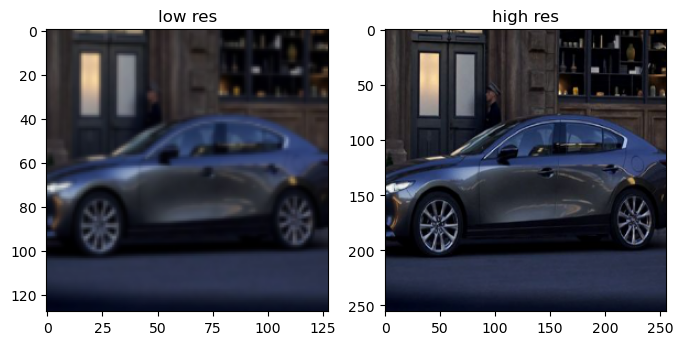

In [5]:
show_image()

#### define the hyperparameters

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"
lr = 3e-4
#lr = 0.0003
epochs = 50
batch_size = 16
num_workers = 2
img_channels = 3

The architecture uses two losses: The normal BCE loss for GANs to create the adversarial loss, and the VGG loss which acts as a perceptual loss for the features. The usual losses try to average the loss so the images in the end are given in a blurry way. However, the VGG loss tries to minimize the difference in perceptual features which gives a kind of a sharper image.

In [7]:
# listing the model to take the required subset of it
test_vgg_model = vgg19(weights=True).eval().to(device)
lf = list(test_vgg_model.features)
lf[25]

/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

In [8]:
class vggL(nn.Module):
    def __init__(self):
        super().__init__()
        self.vgg = vgg19(pretrained=True).features[:25].eval().to(device)
        self.loss = nn.MSELoss()

    def forward(self, first, second):
        vgg_first = self.vgg(first)
        vgg_second = self.vgg(second)
        perceptual_loss = self.loss(vgg_first, vgg_second)
        return perceptual_loss

### The architecture follows the original paper's implementation with some minor changes

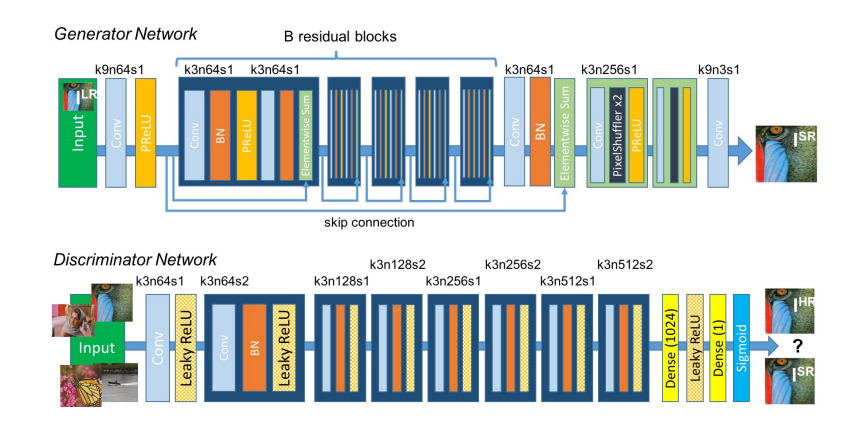

In [9]:
class ConvBlock(nn.Module):
    # Conv -> BN -> leakyReLU
    def __init__(
            self,
            in_channels,
            out_channels,
            use_activation=True,
            use_BatchNorm=True,
            **kwargs
    ):
        
        super().__init__()
        self.use_activation = use_activation
        self.cnn = nn.Conv2d(in_channels, out_channels, **kwargs)
        self.bn = nn.BatchNorm2d(out_channels) if use_BatchNorm else nn.Identity()
        self.ac = (
            nn.LeakyReLU(0.2, inplace=True)
        )

    def forward(self, x):
        x1 = self.cnn(x)
        x2 = self.bn(x1)
        x3 = self.ac(x2)
        return x3 if self.use_activation else x2

In [10]:
class UpsampleBlock(nn.Module):
    def __init__(self, in_channels, scale_factor):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, in_channels * scale_factor ** 2, 2, 1, 1)
        self.ps = nn.PixelShuffle(scale_factor)
        self.ac = nn.PReLU(num_parameters=in_channels)

    def forward(self, x):
        return self.ac(self.ps(self.conv(x)))

In [11]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.b1 = ConvBlock(
            in_channels,
            in_channels,
            kernel_size=3,
            stride=1,
            padding=1
        )

        self.b2 = ConvBlock(
            in_channels,
            in_channels,
            kernel_size=3,
            stride=1,
            padding=1,
            use_activation=False
        )

    def forward(self, x):
        out = self.b1(x)
        out = self.b2(out)
        return out + x

In [12]:
class Generator(nn.Module):
    def __init__(self, in_channels=3, num_channels=64, num_blocks=16):
        super().__init__()
        self.initial = ConvBlock(in_channels, num_channels, kernel_size=7, stride=1, padding=4, use_BatchNorm=False)
        self.res = nn.Sequential(*[ResidualBlock(num_channels) for i in range(num_blocks)])
        self.conv = ConvBlock(num_channels, num_channels, kernel_size=3, stride=1, padding=1, use_activation=False)
        self.up = nn.Sequential(UpsampleBlock(num_channels, scale_factor=2)) 
        self.final = nn.Conv2d(num_channels, in_channels, kernel_size=9, stride=1, padding=1)

    def forward(self, x):
        x = self.initial(x)
        c = self.res(x)
        c = self.conv(c) + x
        c = self.up(c)
        return torch.sigmoid(self.final(c))

In [13]:
class Discriminator(nn.Module):
    def __init__(self, in_channels=3, features=[64, 64, 128, 128, 256, 256, 512, 512]):
        super().__init__()
        blocks = []
        for idx, feature in enumerate(features):
            blocks.append(
                ConvBlock(
                    in_channels,
                    feature,
                    kernel_size=3,
                    stride = idx % 2 + 1,
                    padding=1,
                    use_activation=True,
                    use_BatchNorm=idx != 0,
                )
            )
            in_channels = feature

        self.blocks = nn.Sequential(*blocks)

        self.mlp = nn.Sequential(
            nn.AdaptiveAvgPool2d((8, 8)),
            nn.Flatten(),
            nn.Linear(512*8*8, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, 1)
        )

    def forward(self, x):
        x = self.blocks(x)
        x = self.mlp(x)
        return x

# helper functions

In [14]:
def plot_examples(gen):
    dataset_test = ImageDataset(root_dir="/kaggle/input/image-super-resolution/dataset/val")
    loader = DataLoader(dataset_test, batch_size=16, num_workers=2)
    
    # Create a figure with two subplots
    fig, axs = plt.subplots(1, 3, figsize=(8, 4))
    chosen_batch = random.randint(0, len(loader)-1)
    for idx, (low_res, high_res) in enumerate(loader):
        if(chosen_batch == idx):
            chosen = random.randint(0, len(low_res)-1)
        
            axs[0].set_axis_off()
            axs[0].imshow(low_res[chosen].permute(1, 2, 0))
            axs[0].set_title("low res")

            with torch.no_grad():
                upscaled_img = gen(low_res[chosen].to(device).unsqueeze(0))
        
            axs[1].set_axis_off()
            axs[1].imshow(upscaled_img.cpu().permute(0, 2, 3, 1)[0])
            axs[1].set_title("predicted")
        
            axs[2].set_axis_off()
            axs[2].imshow(high_res[chosen].permute(1, 2, 0))
            axs[2].set_title("high res")
        
            if(idx == 1):
                break
            
    # Show the figure
    plt.show()      
    
    gen.train()

In [15]:
from IPython.display import clear_output
import matplotlib.pyplot as plt

def train_progress(epoch, num_epochs, d_losses, g_losses):
    clear_output(wait=True)
    plt.figure(figsize=(10,5))
    plt.title("Training progress")
    plt.plot(d_losses,label="Discriminator loss")
    plt.plot(g_losses,label="Generator loss")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

    print(f"Epoch [{epoch}/{num_epochs}], Discriminator loss: {d_losses[-1]:.4f}, Generator loss: {g_losses[-1]:.4f}")

# the training loop

In [16]:
# define the generator / discriminator / and other hyperparameters (not already defined above)
gen = Generator(in_channels=3).to(device)
disc = Discriminator(in_channels=3).to(device)
opt_gen = optim.Adam(gen.parameters(), lr=lr, betas=(0.9, 0.999))
opt_disc = optim.Adam(disc.parameters(), lr=lr, betas=(0.9, 0.999))
mse = nn.MSELoss()
bce = nn.BCEWithLogitsLoss()
vgg_loss = vggL()

/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "


In [17]:
# the data loaders for training and validation
train = ImageDataset(root_dir="/kaggle/input/withgaussianfilter/train")
train_loader = DataLoader(train, batch_size=batch_size, num_workers=num_workers)

val = ImageDataset(root_dir="/kaggle/input/image-super-resolution/dataset/val")
val_loader = DataLoader(val, batch_size=batch_size, num_workers=num_workers)

In [18]:
def train_fn(loader, disc, gen, opt_gen, opt_disc, mse, bce, vgg_loss):
    loop = tqdm(train_loader)
    disc_loss = 0
    gen_loss = 0

    for idx, (low_res, high_res) in enumerate(loop):
        high_res = high_res.to(device)
        low_res = low_res.to(device)
        
        ### Train Discriminator: max log(D(x)) + log(1 - D(G(z)))
        fake = gen(low_res)
        
        disc_real = disc(high_res)
        disc_fake = disc(fake.detach())
        
        disc_loss_real = bce(disc_real, torch.ones_like(disc_real))
        disc_loss_fake = bce(disc_fake, torch.zeros_like(disc_fake))
        
        disc_loss = disc_loss_fake + disc_loss_real

        opt_disc.zero_grad()
        disc_loss.backward()
        opt_disc.step()

        # Train Generator: min log(1 - D(G(z))) <-> max log(D(G(z))
        disc_fake = disc(fake)
        adversarial_loss = 1e-3 * bce(disc_fake, torch.ones_like(disc_fake))
        loss_for_vgg = 0.006 * vgg_loss(fake, high_res)
        gen_loss = loss_for_vgg + adversarial_loss

        opt_gen.zero_grad()
        gen_loss.backward()
        opt_gen.step()

            
    return gen_loss.detach().cpu(), disc_loss.detach().cpu()

In [19]:
#run once
d_losses = []
g_losses = []
i = 0

In [20]:
epochs = 10

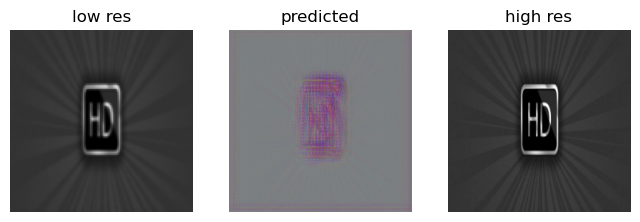

epoch  0 / 10


  0%|          | 0/56 [00:00<?, ?it/s]

Gen loss:  tensor(0.0147) , Disc loss:  tensor(1.4999)


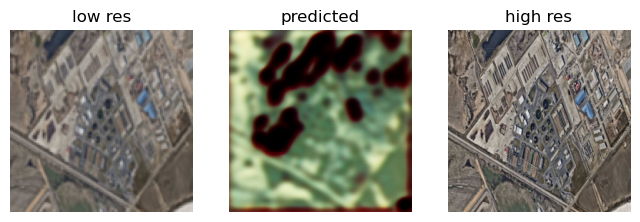

epoch  1 / 10


  0%|          | 0/56 [00:00<?, ?it/s]

Gen loss:  tensor(0.0161) , Disc loss:  tensor(2.3645)


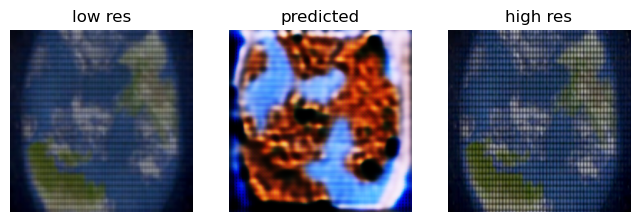

epoch  2 / 10


  0%|          | 0/56 [00:00<?, ?it/s]

Gen loss:  tensor(0.0120) , Disc loss:  tensor(3.5178)


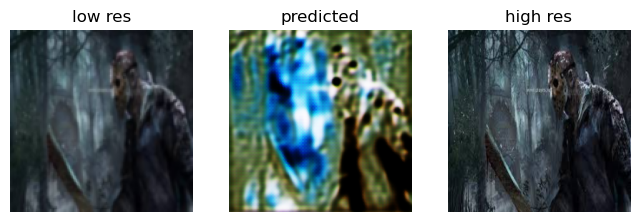

epoch  3 / 10


  0%|          | 0/56 [00:00<?, ?it/s]

Gen loss:  tensor(0.0167) , Disc loss:  tensor(0.2542)


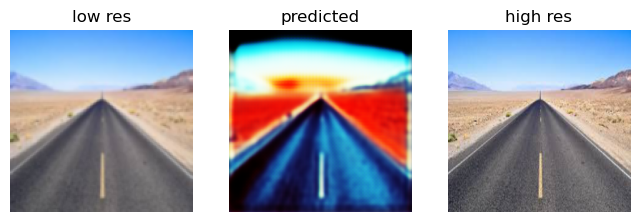

epoch  4 / 10


  0%|          | 0/56 [00:00<?, ?it/s]

Gen loss:  tensor(0.0115) , Disc loss:  tensor(0.6614)


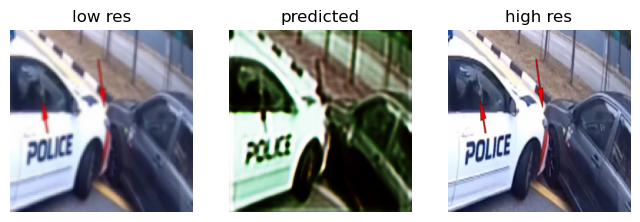

epoch  5 / 10


  0%|          | 0/56 [00:00<?, ?it/s]

Gen loss:  tensor(0.0118) , Disc loss:  tensor(0.7999)


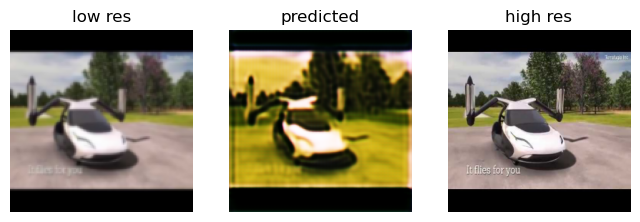

epoch  6 / 10


  0%|          | 0/56 [00:00<?, ?it/s]

Gen loss:  tensor(0.0128) , Disc loss:  tensor(0.5332)


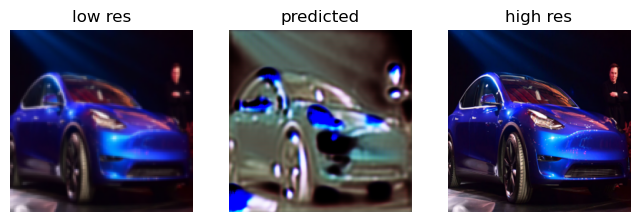

epoch  7 / 10


  0%|          | 0/56 [00:00<?, ?it/s]

Gen loss:  tensor(0.0105) , Disc loss:  tensor(0.9406)


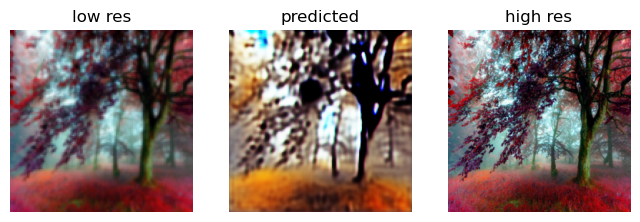

epoch  8 / 10


  0%|          | 0/56 [00:00<?, ?it/s]

Gen loss:  tensor(0.0136) , Disc loss:  tensor(0.4749)


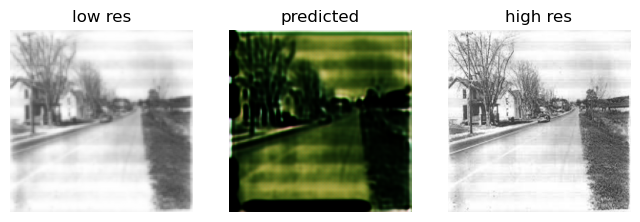

epoch  9 / 10


  0%|          | 0/56 [00:00<?, ?it/s]

Gen loss:  tensor(0.0128) , Disc loss:  tensor(0.7663)


In [21]:

for epoch in range(epochs):
    plot_examples(gen)
    print("epoch ", i, "/", epochs)
    gen_loss, disc_loss = train_fn(train_loader, disc, gen, opt_gen, opt_disc, mse, bce, vgg_loss)
    print('Gen loss: ', gen_loss, ', Disc loss: ', disc_loss)
         # train discriminator and generator and update losses
    d_losses.append(disc_loss)
    g_losses.append(gen_loss)
    i = i + 1
    if i > 40:
        savedir = 'save_' + str(i) + '/'
        os.mkdir(savedir)
        torch.save(gen.state_dict(), savedir + "checkpoint1_gen")
        torch.save(disc.state_dict(), savedir + "checkpoint1_disc")
    
    
     


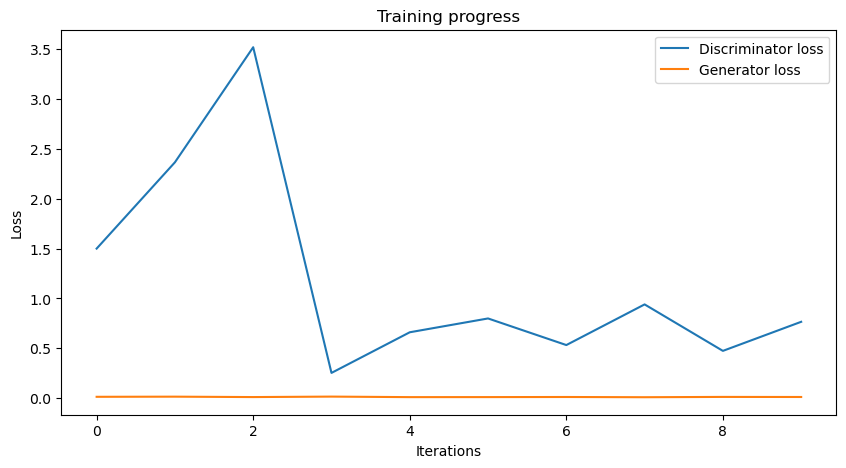

Epoch [9/60], Discriminator loss: 0.7663, Generator loss: 0.0128


In [22]:
# print progress
#plot_examples(gen)
train_progress(epoch, 60, d_losses, g_losses)

In [23]:
def plot_generated(gen):
    dataset_test = ImageDataset(root_dir="/kaggle/input/image-super-resolution/dataset/val")
    loader = DataLoader(dataset_test, batch_size=16, num_workers=2)
    
    # Create a figure with two subplots
    fig, axs = plt.subplots(1, 3, figsize=(15, 10))
    chosen_batch = random.randint(0, len(loader)-1)
    for idx, (low_res, high_res) in enumerate(loader):
        if(chosen_batch == idx):
            chosen = random.randint(0, len(low_res)-1)
        
            axs[0].set_axis_off()
            axs[0].imshow(low_res[chosen].permute(1, 2, 0))
            axs[0].set_title("low res")

            with torch.no_grad():
                upscaled_img = gen(low_res[chosen].to(device).unsqueeze(0))
        
            axs[1].set_axis_off()
            axs[1].imshow(upscaled_img.cpu().permute(0, 2, 3, 1)[0])
            axs[1].set_title("predicted")
        
            axs[2].set_axis_off()
            axs[2].imshow(high_res[chosen].permute(1, 2, 0))
            axs[2].set_title("high res")
        
            if(idx == 1):
                break
            
    # Show the figure
    plt.show()   

In [24]:
print(d_losses)
print(g_losses)

[tensor(1.4999), tensor(2.3645), tensor(3.5178), tensor(0.2542), tensor(0.6614), tensor(0.7999), tensor(0.5332), tensor(0.9406), tensor(0.4749), tensor(0.7663)]
[tensor(0.0147), tensor(0.0161), tensor(0.0120), tensor(0.0167), tensor(0.0115), tensor(0.0118), tensor(0.0128), tensor(0.0105), tensor(0.0136), tensor(0.0128)]


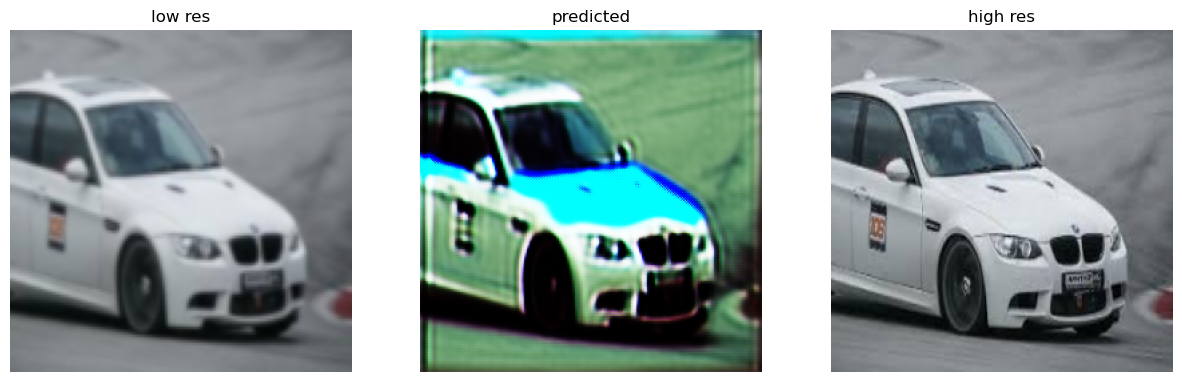

In [25]:
plot_generated(gen)

In [26]:
def train_progress2(epoch, num_epochs, d_losses, g_losses):
    clear_output(wait=True)
    plt.figure(figsize=(10,5))
    plt.title("Training progress")
    plt.plot(g_losses,label="Generator loss")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

    print(f"Epoch [{epoch}/{num_epochs}], Discriminator loss: {d_losses[-1]:.4f}, Generator loss: {g_losses[-1]:.4f}")

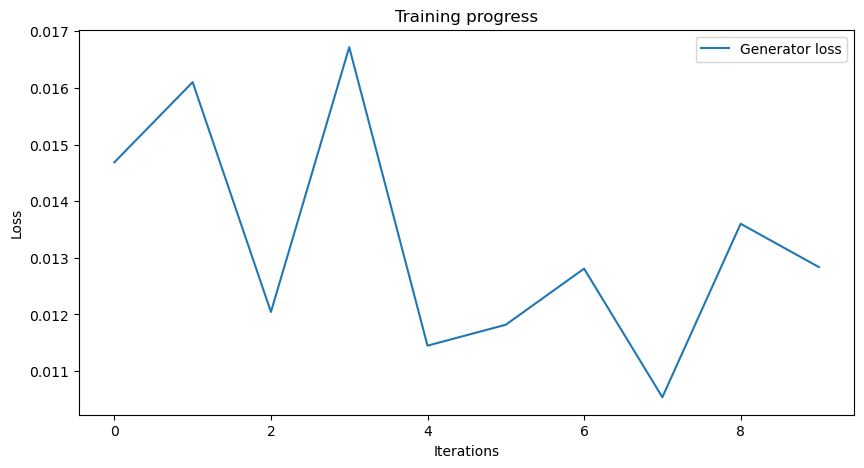

Epoch [9/60], Discriminator loss: 0.7663, Generator loss: 0.0128


In [27]:
train_progress2(epoch, 60, d_losses, g_losses)

In [28]:
a = 0
for ele in g_losses:
    a = a + 1
    if(a == 30): print(ele)
    if(a == 49): print(ele)
    if(a == 50): print(ele)

<class 'numpy.ndarray'>
torch.Size([3, 128, 128])
3


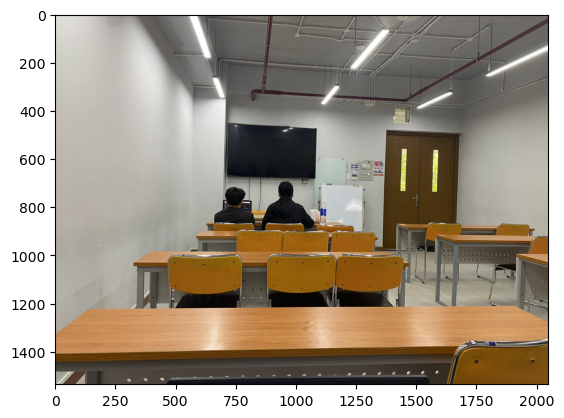

In [29]:
import torchvision
#testing = torchvision.io.read_image('/kaggle/input/low222222/low2.jpg')
testing = cv2.imread('/kaggle/input/animetestimg/fortesting.jpg')
testing = cv2.cvtColor(testing, cv2.COLOR_BGR2RGB)
plt.imshow(testing)
print(type(testing))
tes = transform_low(testing)
print(tes.shape)
print(len(tes.shape))
#transform = transforms.Compose([transforms.ToTensor()])
#tensortest = transform(testing)
#upsc = getupscaledimg(tensortest)

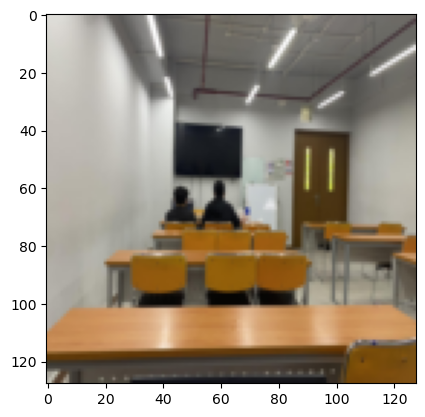

In [30]:
plt.imshow(tes.permute(1,2,0))

In [31]:
def upscaledimg(img):
    img = transform_low(img)
    with torch.no_grad():
        upscaled_img = gen(img.to(device).unsqueeze(0))
    #plt.imshow(upscaled_img.cpu().permute(0, 2, 3, 1)[0])
    return upscaled_img

In [32]:
upscaledimghw = upscaledimg(testing)

print(len(upscaledimghw.shape))

4


In [33]:
from skimage import exposure
from skimage.exposure import match_histograms
from PIL import Image
import torchvision.transforms as T

In [34]:
def tensor_to_image(tensor):
    tensor = tensor*255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor)>3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    return Image.fromarray(tensor)

In [35]:
def with_histogram_matching(img_source):
    upscaled_img = upscaledimg(img_source)
    upscaled_img = torch.reshape(upscaled_img, (3, 256, 256))
    upscaled_img = upscaled_img.cpu().permute(1, 2, 0).numpy()
    
    image = upscaled_img
    reference = img_source/255
    
    matched = match_histograms(image, reference ,
                           multichannel=True)


    fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3,
                                        figsize=(10, 10),
                                        sharex=True, sharey=True)

    for aa in (ax1, ax2, ax3):
        aa.set_axis_off()
    reference = cv2.resize(reference, (128, 128))
    reference = cv2.resize(reference, (256, 256))
    
    ax1.imshow(image)
    ax1.set_title('Generated image')
    ax2.imshow(reference)
    ax2.set_title('Low resolution')
    ax3.imshow(matched)
    ax3.set_title('Genertated with histogram matching')

    plt.tight_layout()
    plt.show()

    fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(8, 8))

    for i, img in enumerate((image, reference, matched)):
        for c, c_color in enumerate(('red', 'green', 'blue')):
            img_hist, bins = exposure.histogram(img[..., c],
                                                source_range='dtype')
            axes[c, i].plot(bins, img_hist / img_hist.max())
            img_cdf, bins = exposure.cumulative_distribution(img[..., c])
            axes[c, i].plot(bins, img_cdf)
            axes[c, 0].set_ylabel(c_color)

    axes[0, 0].set_title('Source')
    axes[0, 1].set_title('Reference')
    axes[0, 2].set_title('Matched')

    plt.tight_layout()
    plt.show()
    return matched
    

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: `multichannel` is a deprecated argument name for `match_histograms`. It will be removed in version 1.0. Please use `channel_axis` instead.
  # Remove the CWD from sys.path while we load stuff.


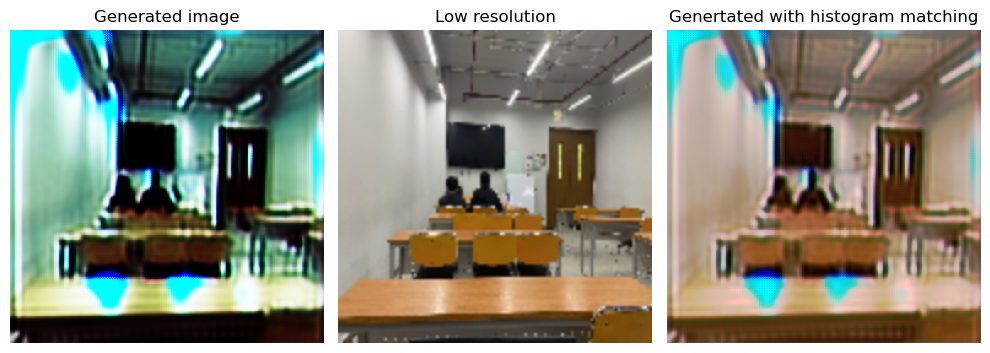

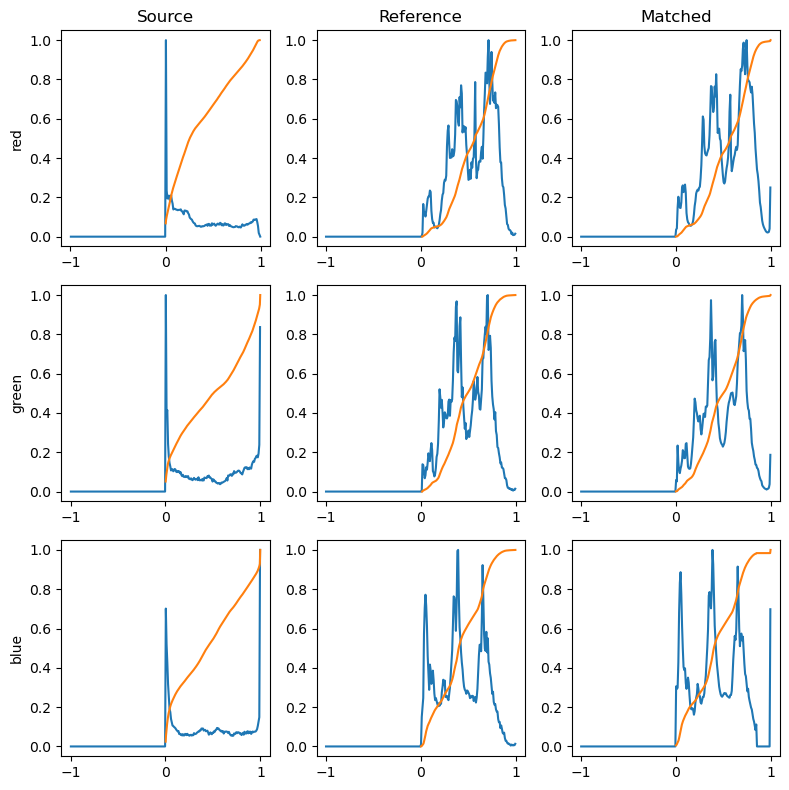

In [36]:
upscaled_with_hmatch= with_histogram_matching(testing) #newest
#print(upscaled_with_hmatch)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: `multichannel` is a deprecated argument name for `match_histograms`. It will be removed in version 1.0. Please use `channel_axis` instead.
  # Remove the CWD from sys.path while we load stuff.


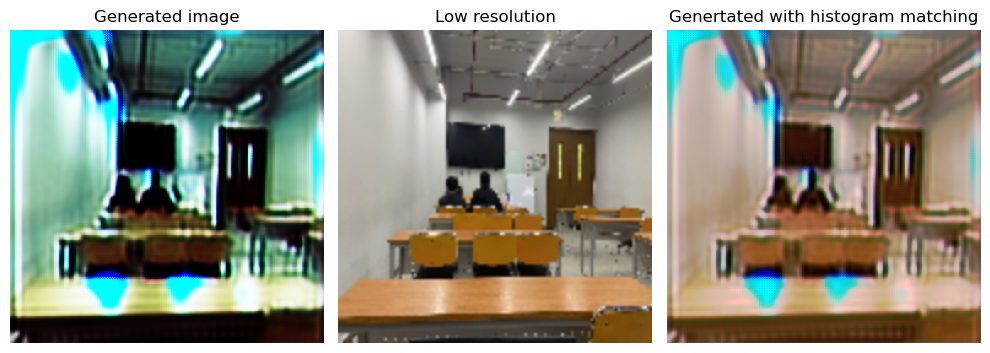

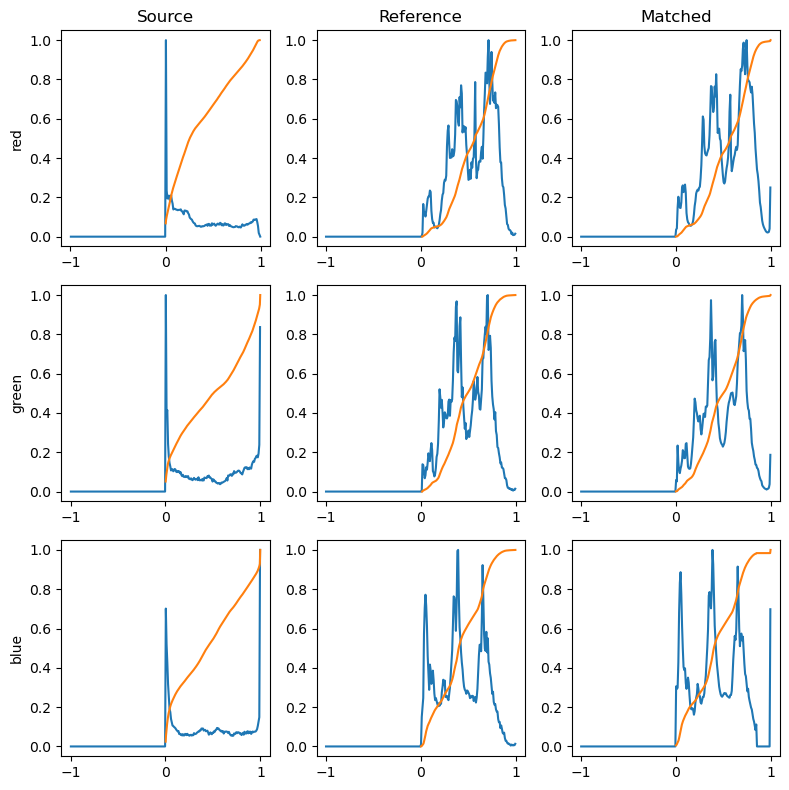

In [37]:
upscaled_with_hmatch= with_histogram_matching(testing)

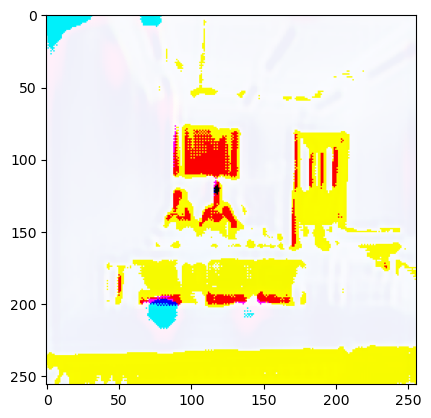

In [38]:
import numpy as np
from scipy import signal


class ExactHistogramMatcher:
    _kernel1 = 1.0 / 5.0 * np.array([[0, 1, 0],
                                     [1, 1, 1],
                                     [0, 1, 0]])

    _kernel2 = 1.0 / 9.0 * np.array([[1, 1, 1],
                                     [1, 1, 1],
                                     [1, 1, 1]])

    _kernel3 = 1.0 / 13.0 * np.array([[0, 0, 1, 0, 0],
                                      [0, 1, 1, 1, 0],
                                      [1, 1, 1, 1, 1],
                                      [0, 1, 1, 1, 0],
                                      [0, 0, 1, 0, 0]])

    _kernel4 = 1.0 / 21.0 * np.array([[0, 1, 1, 1, 0],
                                      [1, 1, 1, 1, 1],
                                      [1, 1, 1, 1, 1],
                                      [1, 1, 1, 1, 1],
                                      [0, 1, 1, 1, 0]])

    _kernel5 = 1.0 / 25.0 * np.array([[1, 1, 1, 1, 1],
                                      [1, 1, 1, 1, 1],
                                      [1, 1, 1, 1, 1],
                                      [1, 1, 1, 1, 1],
                                      [1, 1, 1, 1, 1]])
    _kernel_mapping = {1: [_kernel1],
                       2: [_kernel1, _kernel2],
                       3: [_kernel1, _kernel2, _kernel3],
                       4: [_kernel1, _kernel2, _kernel3, _kernel4],
                       5: [_kernel1, _kernel2, _kernel3, _kernel4, _kernel5]}

    @staticmethod
    def get_histogram(image, image_bit_depth=8):
        """
        :param image: image as numpy array
        :param image_bit_depth: bit depth of the image. Most images have 8 bit.
        :return:
        """
        max_grey_value = pow(2, image_bit_depth)

        if len(image.shape) == 3:
            dimensions = image.shape[2]
            hist = np.empty((max_grey_value, dimensions))

            for dimension in range(0, dimensions):
                for gray_value in range(0, max_grey_value):
                    image_2d = image[:, :, dimension]
                    hist[gray_value, dimension] = len(image_2d[image_2d == gray_value])
        else:
            hist = np.empty((max_grey_value,))

            for gray_value in range(0, max_grey_value):
                hist[gray_value] = len(image[image == gray_value])

        return hist

    @staticmethod
    def _get_averaged_images(img, kernels):
        return np.array([signal.convolve2d(img, kernel, 'same') for kernel in kernels])

    @staticmethod
    def _get_average_values_for_every_pixel(img, number_kernels):
        """
        :param img: the image to be used in order to calculate averaged images
        :param number_kernels: number of kernels to be used in order to calculate the averaged images
        :return: averaged images with the shape:
                 (image height * image width, number averaged images)
                 Every row represents one pixel and its averaged values.
                 I. e. x[0] represents the first pixel and contains an array with k
                 averaged pixels where k are the number of used kernels.
        """
        kernels = ExactHistogramMatcher._kernel_mapping[number_kernels]
        averaged_images = ExactHistogramMatcher._get_averaged_images(img, kernels)
        img_size = averaged_images[0].shape[0] * averaged_images[0].shape[1]

        # shape of averaged_images: (number averaged images, height, width).
        # Reshape in a way, that one row contains all averaged values of pixel in position (x, y)
        reshaped_averaged_images = averaged_images.reshape((number_kernels, img_size))
        transposed_averaged_images = reshaped_averaged_images.transpose()
        return transposed_averaged_images

    @staticmethod
    def sort_rows_lexicographically(matrix):
        # Because lexsort in numpy sorts after the last row,
        # then after the second last row etc., we have to rotate
        # the matrix in order to sort all rows after the first column,
        # and then after the second column etc.

        rotated_matrix = np.rot90(matrix)

        # TODO lexsort is very memory hungry! If the image is too big, this can result in SIG 9!
        sorted_indices = np.lexsort(rotated_matrix)
        return matrix[sorted_indices]

    @staticmethod
    def _match_to_histogram(image, reference_histogram, number_kernels):
        """
        :param image: image as numpy array.
        :param reference_histogram: reference histogram as numpy array
        :param number_kernels: The more kernels you use in order to calculate average images,
                               the more likely it is, the resulting image will have the exact
                               histogram like the reference histogram
        :return: The image with the exact reference histogram.
        """
        img_size = image.shape[0] * image.shape[1]

        merged_images = np.empty((img_size, number_kernels + 2))

        # The first column are the original pixel values.
        merged_images[:, 0] = image.reshape((img_size,))

        # The last column of this array represents the flattened image indices.
        # These indices are necessary to keep track of the pixel positions
        # after they haven been sorted lexicographically according their values.
        indices_of_flattened_image = np.arange(img_size).transpose()
        merged_images[:, -1] = indices_of_flattened_image

        # Calculate average images and add them to merged_images
        averaged_images = ExactHistogramMatcher._get_average_values_for_every_pixel(image, number_kernels)
        for dimension in range(0, number_kernels):
            merged_images[:, dimension + 1] = averaged_images[:, dimension]

        # Sort the array according the original pixels values and then after
        # the average values of the respective pixel
        sorted_merged_images = ExactHistogramMatcher.sort_rows_lexicographically(merged_images)

        # Assign gray values according the distribution of the reference histogram
        index_start = 0
        for gray_value in range(0, len(reference_histogram)):
            index_end = int(index_start + reference_histogram[gray_value])
            sorted_merged_images[index_start:index_end, 0] = gray_value
            index_start = index_end

        # Sort back ordered by the flattened image index. The last column represents the index
        sorted_merged_images = sorted_merged_images[sorted_merged_images[:, -1].argsort()]
        new_target_img = sorted_merged_images[:, 0].reshape(image.shape)

        return new_target_img

    @staticmethod
    def match_image_to_histogram(image, reference_histogram, number_kernels=5):
        """
        :param image: image as numpy array.
        :param reference_histogram: reference histogram as numpy array
        :param number_kernels: The more kernels you use in order to calculate average images,
                               the more likely it is, the resulting image will have the exact
                               histogram like the reference histogram
        :return: The image with the exact reference histogram.
                 CAUTION: Don't save the image in a lossy format like JPEG,
                 because the compression algorithm will alter the histogram!
                 Use lossless formats like PNG.
        """
        if len(image.shape) == 3:
            # Image with more than one dimension. I. e. an RGB image.
            output = np.empty(image.shape)
            dimensions = image.shape[2]

            for dimension in range(0, dimensions):
                output[:, :, dimension] = ExactHistogramMatcher._match_to_histogram(image[:, :, dimension],
                                                                                    reference_histogram[:, dimension],
                                                                                    number_kernels)
        else:
            # Gray value image
            output = ExactHistogramMatcher._match_to_histogram(image,
                                                               reference_histogram,
                                                               number_kernels)

        return output
    
import imageio.v2 as imageio


def histogram_matching_rgb(img_source):
    upscaled_img = upscaledimg(img_source)
    upscaled_img = torch.reshape(upscaled_img, (3, 256, 256))
    upscaled_img = upscaled_img.cpu().permute(1, 2, 0).numpy()
    
    image = upscaled_img
    reference = img_source/255
    
    target_img = upscaled_img
    reference_img = img_source
    #target_img = imageio.imread('/kaggle/input/animetestimg/Luna_medium.jpg')
    #reference_img = imageio.imread('/kaggle/input/animetestimg/Luna_White_Balance_medium.jpg')

    reference_histogram = ExactHistogramMatcher.get_histogram(reference_img)

    new_target_img = ExactHistogramMatcher.match_image_to_histogram(target_img, reference_histogram)
    new_target_img = (new_target_img * 255).astype(np.uint8)
    plt.imshow(new_target_img)

histogram_matching_rgb(testing)

In [39]:
def with_histogram_matching_2(img_source):
    upscaled_img = upscaledimg(img_source)
    upscaled_img = torch.reshape(upscaled_img, (3, 256, 256))
    upscaled_img = upscaled_img.cpu().permute(1, 2, 0).numpy()
    
    image = upscaled_img
    reference = img_source/255
    
    matched = match_histograms(image, reference ,
                           multichannel=True)
    return matched

# Save the model

In [40]:
torch.save(gen.state_dict(), "checkpoint1_gen_withgaussdata48")
torch.save(disc.state_dict(), "checkpoint1_disc_withgaussdata48")

In [41]:
gen.load_state_dict(torch.load('/kaggle/input/modelspytorch/checkpoint1_gen_withgaussdata48', map_location=torch.device('cpu')))
disc.load_state_dict(torch.load('/kaggle/input/modelspytorch/checkpoint1_disc_withgaussdata48', map_location=torch.device('cpu')))

<All keys matched successfully>

In [42]:
#delete output on kaggle
def remove_folder_contents(folder):
    for the_file in os.listdir(folder):
        file_path = os.path.join(folder, the_file)
        try:
            if os.path.isfile(file_path):
                os.unlink(file_path)
            elif os.path.isdir(file_path):
                remove_folder_contents(file_path)
                os.rmdir(file_path)
        except Exception as e:
            print(e)

In [43]:
val_set_high = []
val_set_low = []


def readimg(path, list):
    for filename in os.listdir(path):
        img = cv2.imread(os.path.join(path,filename))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        if img is not None:
            list.append(img)
            
def readimgnormalized(path, list):
    for filename in os.listdir(path):
        img = cv2.imread(os.path.join(path,filename))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)/255
        if img is not None:
            list.append(img)
    

In [44]:
readimgnormalized('/kaggle/input/image-super-resolution/dataset/val/high_res', val_set_high)
readimg('/kaggle/input/image-super-resolution/dataset/val/low_res', val_set_low)

170
170


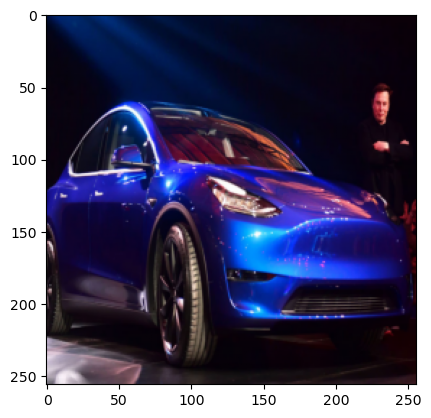

In [45]:
print(len(val_set_high))
print(len(val_set_low))
plt.imshow(val_set_high[30])

In [46]:
#create val_predicted set
val_predicted = []
for image in val_set_low:
    predhis = with_histogram_matching_2(image)
    val_predicted.append(predhis)



/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: `multichannel` is a deprecated argument name for `match_histograms`. It will be removed in version 1.0. Please use `channel_axis` instead.
  # Remove the CWD from sys.path while we load stuff.


In [47]:
def mse(imageA, imageB):
    err = np.mean((imageA - imageB) ** 2)
    return err

In [48]:
mse_values = []
for pred,ori in zip(val_predicted, val_set_high):
    mse_value = mse(pred, ori)
    mse_values.append(mse_value)
    

In [49]:
print(mse_values)

[0.0015454456855422682, 0.0009305428654481639, 0.0010273040060210868, 0.0031900770236313217, 0.001753437350267121, 0.004071773607762252, 0.004460696408978784, 0.0016923075678774325, 0.0016040429106808616, 0.0021171915863371885, 0.00212877252414776, 0.001761341219392941, 0.0018083410214781975, 0.0013537014228820015, 0.002030209155354575, 0.001447950853960032, 0.0013779972530346416, 0.002064209216120065, 0.0017309866031565144, 0.002174561973687862, 0.0020491102664771713, 0.0068527547164085635, 0.0012216127173732961, 0.0020149988203509105, 0.0013805587035605313, 0.0032934195663401095, 0.0015883304819420078, 0.002878683768914578, 0.0013089666011839795, 0.0033650473180473275, 0.002872350855152497, 0.0043429583237210604, 0.0011269105529811269, 0.0028135581585048215, 0.002654646830849108, 0.00335854355662279, 0.0021231319704387323, 0.0012243741305113765, 0.00362670662150744, 0.0013045982893070737, 0.002288659273574679, 0.00401072366037944, 0.0006610091677822365, 0.0010421698084434254, 0.00144

In [50]:
sum = 0
for value in mse_values:
    sum = sum + value
print(f'sum: {sum}, sum/n:{sum/170}')

sum: 0.3932557344322925, sum/n:0.002313269026072309


In [51]:
#latest
sum = 0
for value in mse_values:
    sum = sum + value
print(f'sum: {sum}, sum/n:{sum/170}')

sum: 0.3932557344322925, sum/n:0.002313269026072309


In [52]:
print(mse_values)

[0.0015454456855422682, 0.0009305428654481639, 0.0010273040060210868, 0.0031900770236313217, 0.001753437350267121, 0.004071773607762252, 0.004460696408978784, 0.0016923075678774325, 0.0016040429106808616, 0.0021171915863371885, 0.00212877252414776, 0.001761341219392941, 0.0018083410214781975, 0.0013537014228820015, 0.002030209155354575, 0.001447950853960032, 0.0013779972530346416, 0.002064209216120065, 0.0017309866031565144, 0.002174561973687862, 0.0020491102664771713, 0.0068527547164085635, 0.0012216127173732961, 0.0020149988203509105, 0.0013805587035605313, 0.0032934195663401095, 0.0015883304819420078, 0.002878683768914578, 0.0013089666011839795, 0.0033650473180473275, 0.002872350855152497, 0.0043429583237210604, 0.0011269105529811269, 0.0028135581585048215, 0.002654646830849108, 0.00335854355662279, 0.0021231319704387323, 0.0012243741305113765, 0.00362670662150744, 0.0013045982893070737, 0.002288659273574679, 0.00401072366037944, 0.0006610091677822365, 0.0010421698084434254, 0.00144

In [53]:
import torch
import torch.nn.functional as F

def calculate_psnr(image1, image2):
    mseror = mse(image1, image2)  # Tính Mean Squared Error (MSE)
    psnr = 10 * np.log10(1 / mseror)  # Tính PSNR từ MSE
    return psnr.item()  # Trả về giá trị PSNR dưới dạng số thực



In [54]:
print(val_predicted[0].shape)
print(val_set_high[0].shape)

(256, 256, 3)
(256, 256, 3)


In [55]:
psnr_list = []
for pred,ori in zip(val_predicted, val_set_high):
    
    psnr = cv2.PSNR(pred.astype('float'), ori.astype('float'), 1)
    psnr_list.append(psnr)
    

In [56]:
print(psnr_list)

[28.1094625354715, 30.31263616301269, 29.88301018330454, 24.9619883088194, 27.561097467025483, 23.90216376946562, 23.505973334478867, 27.715207034169836, 27.947840178332424, 26.74239840552008, 26.718707438155576, 27.541565013045087, 27.427196657962597, 28.68477114597694, 26.924592180783087, 28.39246178619654, 28.6075164817083, 26.85246287276541, 27.61706293301794, 26.626282106948405, 26.884346707671362, 21.641348127932435, 29.130664547857013, 26.957252037736033, 28.599451217372355, 24.82352938665818, 27.990591293956626, 25.40806040908146, 28.830714345084793, 24.730088245091387, 25.41762512497253, 23.62214338232703, 29.48110554129901, 25.507441032017653, 25.7599324844903, 24.738490150061146, 26.730230099545768, 29.120858550750626, 24.404875747790125, 28.84523195294582, 26.404188585359485, 23.96777259959685, 31.797925170807243, 29.82061512455326, 28.41116493486695, 27.02754601461546, 27.39814638348102, 27.723854673195156, 23.29357236828555, 28.0937045259222, 21.346869247738162, 20.927582

In [57]:
sum_psnr = 0
for psnr in psnr_list:
    sum_psnr = sum_psnr + psnr
    
print(sum_psnr/170)

27.280232347215367


In [58]:
sum_psnr = 0
for psnr in psnr_list:
    sum_psnr = sum_psnr + psnr
    
print(sum_psnr)

4637.639499026613


In [59]:
sum_psnr/170

27.280232347215367

In [60]:
10*np.log10(1/(sum/170))

26.3577385717985

In [61]:
testimg1 = cv2.imread('/kaggle/input/image-super-resolution/dataset/val/high_res/0.png')/255
testimg2 = cv2.imread('/kaggle/input/image-super-resolution/dataset/val/high_res/0.png')/255
psnrtest = cv2.PSNR(val_predicted[0].astype('float'),testimg2.astype('float'))
print(psnrtest)
print(type(testimg1))
print(testimg1.shape)
print(type(val_predicted[0]))
print(val_predicted[0].shape)


55.22642741536952
<class 'numpy.ndarray'>
(256, 256, 3)
<class 'numpy.ndarray'>
(256, 256, 3)


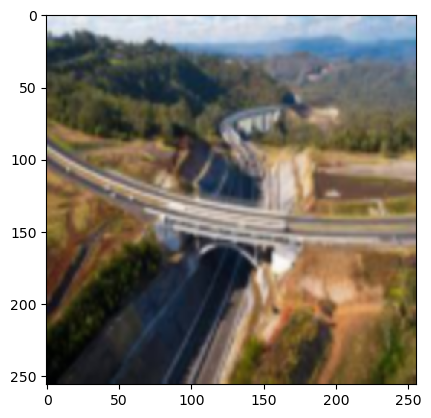

In [62]:
plt.imshow(val_set_low[4])

# References:
<ul>
    <li>https://arxiv.org/abs/1609.04802
    <li>https://github.com/aladdinpersson/Machine-Learning-Collection/tree/master/ML/Pytorch/GANs/SRGAN
    <li>https://www.geeksforgeeks.org/super-resolution-gan-srgan/
    <li>and of course a lot of stackoverflow, and pytorch docs
</ul>

# To Do:

#### Add validation metrics using PSNR, SSIM, and MSE